Walk through two key unsupervised learning algorithms: clustering and anomaly detection.

#### Helpers

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

In [7]:
def load_clustering_data():
    X = np.load("data/clustering/ex7_X.npy")
    return X

def draw_line(p1, p2, style="-k", linewidth=1):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], style, linewidth=linewidth)

def plot_data_points(X, idx):
    # Define colormap to match Figure 1 in the notebook
    cmap = ListedColormap(["red", "green", "blue"])
    c = cmap(idx)
    
    # plots data points in X, coloring them so that those with the same
    # index assignments in idx have the same color
    plt.scatter(X[:, 0], X[:, 1], facecolors='none', edgecolors=c, linewidth=0.1, alpha=0.7)

def plot_progress_kMeans(X, centroids, previous_centroids, idx, K, i):
    # Plot the examples
    plot_data_points(X, idx)
    
    # Plot the centroids as black 'x's
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='k', linewidths=3)
    
    # Plot history of the centroids with lines
    for j in range(centroids.shape[0]):
        draw_line(centroids[j, :], previous_centroids[j, :])
    
    plt.title("Iteration number %d" %i)

#### Clustering (K-means algorithm)

The K-means algorithm is a method to automatically cluster similar
data points together. 

* Concretely, you are given a training set $\{x^{(1)}, ..., x^{(m)}\}$, and you want
to group the data into a few cohesive “clusters”. 


* K-means is an iterative procedure that
     * Starts by guessing the initial centroids, and then 
     * Refines this guess by 
         * Repeatedly assigning examples to their closest centroids, and then 
         * Recomputing the centroids based on the assignments.
         

* In pseudocode, the K-means algorithm is as follows:

    ``` python
    # Initialize centroids
    # K is the number of clusters
    centroids = kMeans_init_centroids(X, K)
    
    for iter in range(iterations):
        # Cluster assignment step: 
        # Assign each data point to the closest centroid. 
        # idx[i] corresponds to the index of the centroid 
        # assigned to example i
        idx = find_closest_centroids(X, centroids)

        # Move centroid step: 
        # Compute means based on centroid assignments
        centroids = compute_centroids(X, idx, K)
    ```


* The inner-loop of the algorithm repeatedly carries out two steps: 
    1. Assigning each training example $x^{(i)}$ to its closest centroid, and
    2. Recomputing the mean of each centroid using the points assigned to it. 
    
    
* The $K$-means algorithm will always converge to some final set of means for the centroids. 

* However, the converged solution may not always be ideal and depends on the initial setting of the centroids.
    * Therefore, in practice the K-means algorithm is usually run a few times with different random initializations. 
    * One way to choose between these different solutions from different random initializations is to choose the one with the lowest cost function value (distortion).

How it works:
1. First we randomly initialize K points called means or cluster centroids $\mu_{1}, \mu_{2}, ..., \mu_{K}$.
2. We categorize each item to its closest mean and we update the mean's coordinates, which are the averages of the items categorized in that cluster so far.
3. We repeat the process for a given number of iterations and at the end, we have our clusters.

Note that with k-means random initialization, we might end up with initial centroids that are too close to each others, or don't yield good clustering, thus one way around it is to run k-means with random initialization several times, then compute the cost function **J** for each one and pick the set of clusters that gave lowest cost **J**.

<b>Finding closest centroids</b>

* This function takes the data matrix `X` and the locations of all
centroids inside `centroids` 
* It should output a one-dimensional array `idx` (which has the same number of elements as `X`) that holds the index  of the closest centroid (a value in $\{0,...,K-1\}$, where $K$ is total number of centroids) to every training example . *(Note: The index range 0 to K-1 varies slightly from what is shown in the lectures (i.e. 1 to K) because Python list indices start at 0 instead of 1)*
* Specifically, for every example $x^{(i)}$ we set
$$c^{(i)} := j \quad \mathrm{that \; minimizes} \quad ||x^{(i)} - \mu_j||^2,$$
where 
 * $c^{(i)}$ is the index of the centroid that is closest to $x^{(i)}$ (corresponds to `idx[i]` in the starter code), and 
 * $\mu_j$ is the position (value) of the $j$’th centroid. (stored in `centroids` in the starter code)
 * $||x^{(i)} - \mu_j||$ is the L2-norm
 


In [1]:
def find_closest_centroids(X, centroids):
    """
    Computes the centroid memberships for every example
    
    Args:
        X (ndarray): (m, n) Input values      
        centroids (ndarray): (K, n) centroids
    
    Returns:
        idx (array_like): (m,) closest centroids
    
    """

    # Set K
    K = centroids.shape[0]

    # You need to return the following variables correctly
    idx = np.zeros(X.shape[0], dtype=int)

    for i in range(X.shape[0]):
        distances = []
        
        for j in range(centroids.shape[0]):
            norm_ij = np.linalg.norm(X[i] - centroids[j])  #
            distances.append(norm_ij)
        
        idx[i] = np.argmin(distances)
    
    return idx

<b>Computing centroid means</b>

* Specifically, for every centroid $\mu_k$ we set
$$\mu_k = \frac{1}{|C_k|} \sum_{i \in C_k} x^{(i)}$$ 

    where 
    * $C_k$ is the set of examples that are assigned to centroid $k$
    * $|C_k|$ is the number of examples in the set $C_k$


* Concretely, if two examples say $x^{(3)}$ and $x^{(5)}$ are assigned to centroid $k=2$,
then you should update $\mu_2 = \frac{1}{2}(x^{(3)}+x^{(5)})$.

In [2]:
def compute_centroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the 
    data points assigned to each centroid.
    
    Args:
        X (ndarray):   (m, n) Data points
        idx (ndarray): (m,) Array containing index of closest centroid for each 
                       example in X. Concretely, idx[i] contains the index of 
                       the centroid closest to example i
        K (int):       number of centroids
    
    Returns:
        centroids (ndarray): (K, n) New centroids computed
    """
    
    # Useful variables
    m, n = X.shape
    
    # You need to return the following variables correctly
    centroids = np.zeros((K, n))
    
    for k in range(K):
        points = X[idx == k]
        centroids[k] = np.mean(points, axis = 0) 
    
    return centroids

<b>K-means on a sample dataset</b>

In [3]:
def run_kMeans(X, initial_centroids, max_iters=10, plot_progress=False):
    """
    Runs the K-Means algorithm on data matrix X, where each row of X
    is a single example
    """
    
    # Initialize values
    m, n = X.shape
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids    
    idx = np.zeros(m)
    plt.figure(figsize=(8, 6))

    # Run K-Means
    for i in range(max_iters):
        
        #Output progress
        print("K-Means iteration %d/%d" % (i, max_iters-1))
        
        # For each example in X, assign it to the closest centroid
        idx = find_closest_centroids(X, centroids)
        
        # Optionally plot progress
        if plot_progress:
            plot_progress_kMeans(X, centroids, previous_centroids, idx, K, i)
            previous_centroids = centroids
            
        # Given the memberships, compute new centroids
        centroids = compute_centroids(X, idx, K)
    plt.show() 
    return centroids, idx

K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9


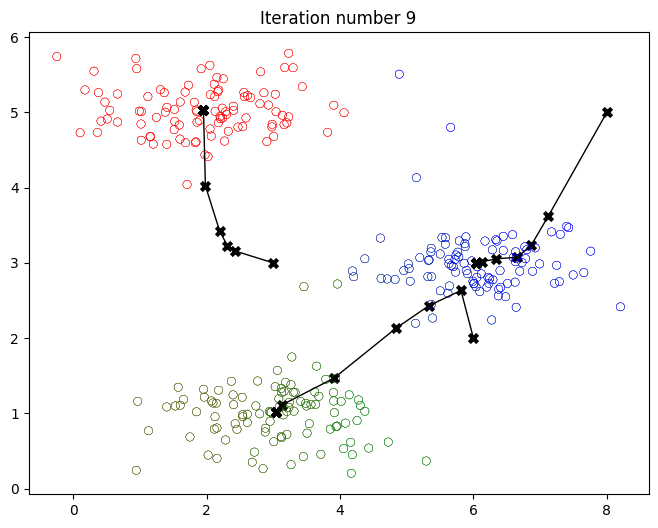

In [10]:
# Load an example dataset
X = load_clustering_data()

# Set initial centroids
initial_centroids = np.array([[3,3],[6,2],[8,5]])

# Number of iterations
max_iters = 10

# Run K-Means
centroids, idx = run_kMeans(X, initial_centroids, max_iters, plot_progress=True)

In [11]:
centroids, idx

(array([[1.95399466, 5.02557006],
        [3.04367119, 1.01541041],
        [6.03366736, 3.00052511]]),
 array([0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        

#### Anomaly Detection

In order to apply anomaly detection, we're going to need to use the Gaussian distribution, which is also called the normal distribution.

Say $x$ is a number; the probability of $x$ is determined by Gaussian with mean $\mu$ and variance $\sigma^{2}$, where the curve can be defined as $p(x) = \frac{1}{\sigma \sqrt{2\pi} } e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2}$.

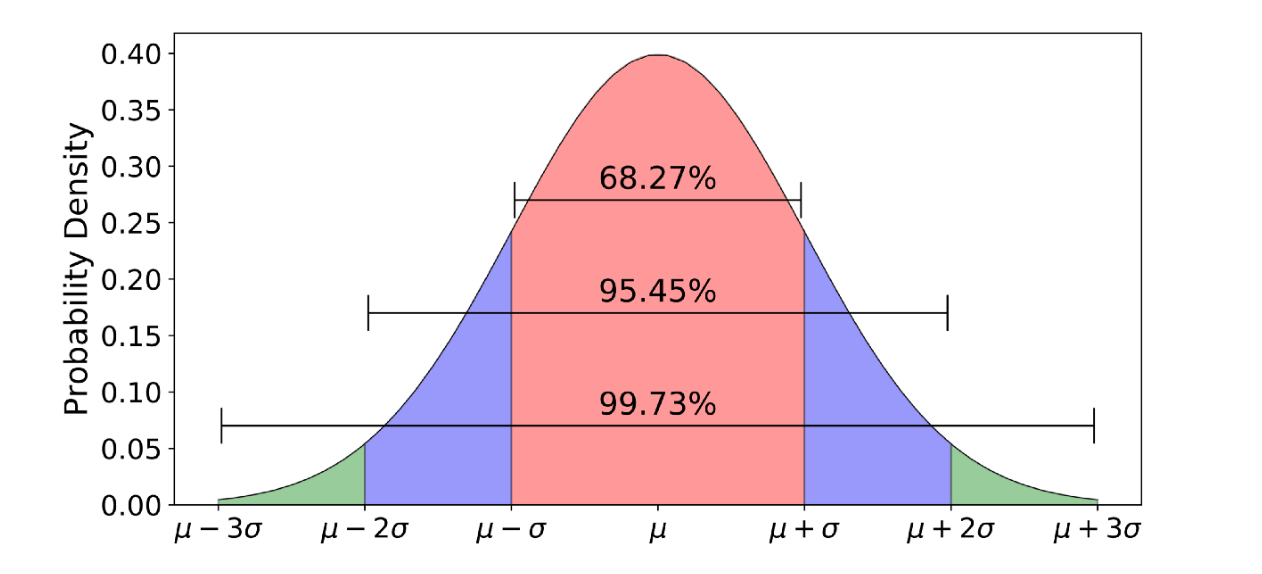

When building an anomaly detection algorithm, choosing a good choice of features turns out to be really important. One step that can help the anomaly detection algorithm, is to try to make sure the features you give it to be more or less Gaussian. And if your features are not Gaussian, sometimes you can change it to make it a little bit more Gaussian.

To know if the features are gaussian, we can plot the histogram and observe the distribution. Gaussian features will have distribution similar to the image above.

If the features are not gaussian, we can perform some operations, for example assume that $x_{1}$ is not a gaussian feature, we can transform it as following:
- $x_{1} \leftarrow log(x_{1})$
- $x_{1} \leftarrow log(x_{1} + C)$ where $C$ is a constant and larger $C$ will perform less transformation.
- $x_{1} \leftarrow \sqrt(x_{1})$
- $x_{1} \leftarrow x_{1}^{1/3}$

Such transformation has to be applied to both validation and test sets if it was applied to the training set.


One target through the error analysis is to have a clear separation between normal and anomalous examples of $x$. For example:
- $p(x) \geq \epsilon$ large for normal examples $x$
- $p(x) \lt \epsilon$ small for anomalous examples $x$

If $p(x)$ is large for both normal and anomalous examples, we may need to take a deeper look at that specific $x$ feature or add another new feature that can make better distinguishing. 

Below is a dataset example to use for developing the algorithm.

The dataset contains two features - 
   * throughput (mb/s) and 
   * latency (ms) of response of each server.

While your servers were operating, you collected $m=307$ examples of how they were behaving, and thus have an unlabeled dataset $\{x^{(1)}, \ldots, x^{(m)}\}$. 
* You suspect that the vast majority of these examples are “normal” (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

You will use a Gaussian model to detect anomalous examples in your
dataset. 
* You will first start on a 2D dataset that will allow you to visualize what the algorithm is doing.
* On that dataset you will fit a Gaussian distribution and then find values that have very low probability and hence can be considered anomalies. 
* After that, you will apply the anomaly detection algorithm to a larger dataset with many dimensions. 

In [7]:
X_train = np.load("data/anomaly/X_part1.npy")
X_val = np.load("data/anomaly/X_val_part1.npy")
y_val = np.load("data/anomaly/y_val_part1.npy")

In [9]:
# Display the first five elements of X_train
print("The first 5 elements of X_train are:\n", X_train[:5])  

# Display the first five elements of X_val
print("The first 5 elements of X_val are\n", X_val[:5])  

# Display the first five elements of y_val
print("The first 5 elements of y_val are\n", y_val[:5])  

The first 5 elements of X_train are:
 [[13.04681517 14.74115241]
 [13.40852019 13.7632696 ]
 [14.19591481 15.85318113]
 [14.91470077 16.17425987]
 [13.57669961 14.04284944]]
The first 5 elements of X_val are
 [[15.79025979 14.9210243 ]
 [13.63961877 15.32995521]
 [14.86589943 16.47386514]
 [13.58467605 13.98930611]
 [13.46404167 15.63533011]]
The first 5 elements of y_val are
 [0 0 0 0 0]


In [10]:
print ('The shape of X_train is:', X_train.shape)
print ('The shape of X_val is:', X_val.shape)
print ('The shape of y_val is: ', y_val.shape)

The shape of X_train is: (307, 2)
The shape of X_val is: (307, 2)
The shape of y_val is:  (307,)


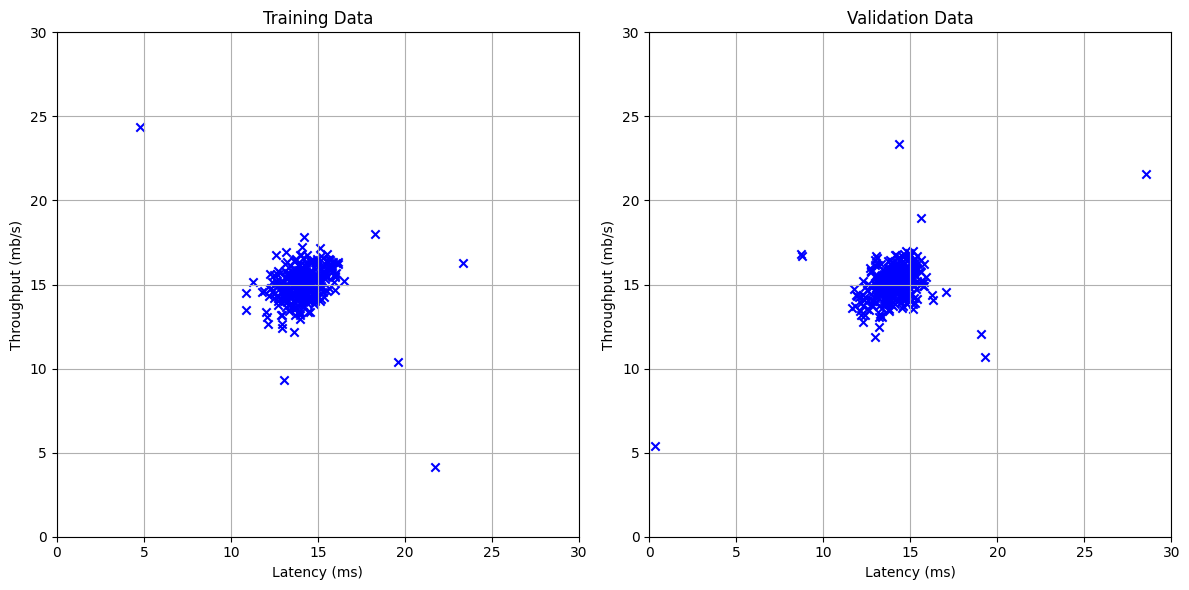

In [29]:
# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Data and titles for each subplot
datasets = [(X_train, "Training Data"), (X_val, "Validation Data")]

for ax, (X, title) in zip(axes, datasets):
    ax.scatter(X[:, 0], X[:, 1], marker='x', color='blue')
    ax.set_title(title)
    ax.set_xlabel("Latency (ms)")
    ax.set_ylabel("Throughput (mb/s)")
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 30)
    ax.grid(True)

plt.tight_layout()
plt.show()

To perform anomaly detection, we will first need to fit a model to the data’s distribution.

* Given a training set $\{x^{(1)}, ..., x^{(m)}\}$ we want to estimate the Gaussian distribution for each
of the features $x_i$. 

* The Gaussian distribution is given by

   $$ p(x ; \mu,\sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}}\exp^{ - \frac{(x - \mu)^2}{2 \sigma ^2} }$$

   where $\mu$ is the mean and $\sigma^2$ is the variance.
   
* For each feature $i = 1\ldots n$, you need to find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i$-th dimension $\{x_i^{(1)}, ..., x_i^{(m)}\}$ (the $i$-th dimension of each example).

* Below is a function to estimate parameters fr a gaussian distribution to calculate `mu` (mean for each feature in `X`) and `var` (variance for each feature in `X`). Note that we can estimate the parameters, ($\mu_i$, $\sigma_i^2$), of the $i$-th
feature by using the following equations. To estimate the mean, we will
use:

$$\mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)}$$

and for the variance you will use:
$$\sigma_i^2 = \frac{1}{m} \sum_{j=1}^m (x_i^{(j)} - \mu_i)^2$$

In [30]:
def estimate_gaussian(X): 
    """
    Calculates mean and variance of all features 
    in the dataset
    
    Args:
        X (ndarray): (m, n) Data matrix
    
    Returns:
        mu (ndarray): (n,) Mean of all features
        var (ndarray): (n,) Variance of all features
    """

    m, n = X.shape
    
    # Performing operations on each feature columns
    mu = (1 / m) * np.sum(X, axis=0)    
    var = (1 / m) * np.sum((X - mu)**2, axis=0)
        
    return mu, var

We can visualize the contours of the fitted gaussian distribution as following:

In [31]:
def multivariate_gaussian(X, mu, var):
    """
    Computes the probability 
    density function of the examples X under the multivariate gaussian 
    distribution with parameters mu and var. If var is a matrix, it is
    treated as the covariance matrix. If var is a vector, it is treated
    as the var values of the variances in each dimension (a diagonal
    covariance matrix
    """
    
    k = len(mu)
    
    if var.ndim == 1:
        var = np.diag(var)
        
    X = X - mu
    p = (2* np.pi)**(-k/2) * np.linalg.det(var)**(-0.5) * \
        np.exp(-0.5 * np.sum(np.matmul(X, np.linalg.pinv(var)) * X, axis=1))
    
    return p
        
def visualize_fit(X, mu, var):
    """
    This visualization shows you the 
    probability density function of the Gaussian distribution. Each example
    has a location (x1, x2) that depends on its feature values.
    """
    
    X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
    Z = multivariate_gaussian(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, var)
    Z = Z.reshape(X1.shape)

    plt.plot(X[:, 0], X[:, 1], 'bx')

    if np.sum(np.isinf(Z)) == 0:
        plt.contour(X1, X2, Z, levels=10**(np.arange(-20., 1, 3)), linewidths=1)
        
    # Set the title
    plt.title("The Gaussian contours of the distribution fit to the dataset")
    # Set the y-axis label
    plt.ylabel('Throughput (mb/s)')
    # Set the x-axis label
    plt.xlabel('Latency (ms)')

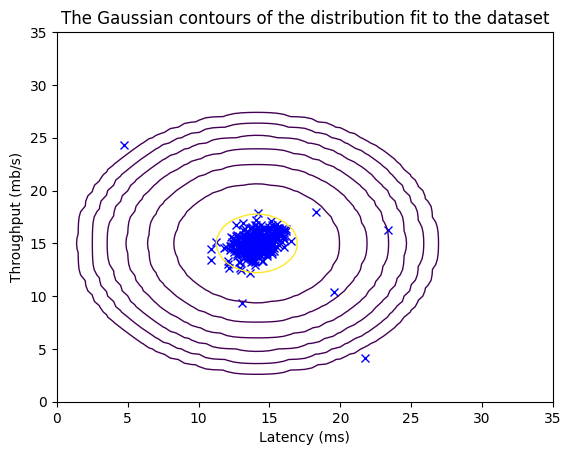

In [33]:
# Estimate mean and variance of each feature
mu, var = estimate_gaussian(X_train)              

# Returns the density of the multivariate normal
# at each data point (row) of X_train
p = multivariate_gaussian(X_train, mu, var)

#Plotting code 
visualize_fit(X_train, mu, var)

Now that we estimated the Gaussian parameters, we can investigate which examples have a very high probability given this distribution and which examples have a very low probability.

* The low probability examples are more likely to be the anomalies in our dataset. 
* One way to determine which examples are anomalies is to select a threshold based on a cross validation set. 

* For this, we will use a cross validation set
$\{(x_{\rm cv}^{(1)}, y_{\rm cv}^{(1)}),\ldots, (x_{\rm cv}^{(m_{\rm cv})}, y_{\rm cv}^{(m_{\rm cv})})\}$, where the label $y=1$ corresponds to an anomalous example, and $y=0$ corresponds to a normal example. 
* For each cross validation example, we will compute $p(x_{\rm cv}^{(i)})$. The vector of all of these probabilities $p(x_{\rm cv}^{(1)}), \ldots, p(x_{\rm cv}^{(m_{\rm cv})})$ is passed to `select_threshold` in the vector `p_val`. 
* The corresponding labels $y_{\rm cv}^{(1)}, \ldots, y_{\rm cv}^{(m_{\rm cv})}$ are passed to the same function in the vector `y_val`.

* In the function below `select_threshold`, there is already a loop that will try many different values of $\varepsilon$ and select the best $\varepsilon$ based on the $F_1$ score. 

* The F1 score is computed from choosing `epsilon` as the threshold and place the value in `F1`. 

  * Recall that if an example $x$ has a low probability $p(x) < \varepsilon$, then it is classified as an anomaly. 
        
  * Then, you can compute precision and recall by: 
   $$\begin{aligned}
   prec&=&\frac{tp}{tp+fp}\\
   rec&=&\frac{tp}{tp+fn},
   \end{aligned}$$ where
    * $tp$ is the number of true positives: the ground truth label says it’s an anomaly and our algorithm correctly classified it as an anomaly.
    * $fp$ is the number of false positives: the ground truth label says it’s not an anomaly, but our algorithm incorrectly classified it as an anomaly.
    * $fn$ is the number of false negatives: the ground truth label says it’s an anomaly, but our algorithm incorrectly classified it as not being anomalous.

  * The $F_1$ score is computed using precision ($prec$) and recall ($rec$) as follows:
    $$F_1 = \frac{2\cdot prec \cdot rec}{prec + rec}$$ 


In [34]:
def select_threshold(y_val, p_val): 
    """
    Finds the best threshold to use for selecting outliers 
    based on the results from a validation set (p_val) 
    and the ground truth (y_val)
    
    Args:
        y_val (ndarray): Ground truth on validation set
        p_val (ndarray): Results on validation set
        
    Returns:
        epsilon (float): Threshold chosen 
        F1 (float):      F1 score by choosing epsilon as threshold
    """ 

    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step_size = (max(p_val) - min(p_val)) / 1000
    
    for epsilon in np.arange(min(p_val), max(p_val), step_size):
    
        predictions = (p_val < epsilon).astype(int)
        
        tp = np.sum((predictions == 1) & (y_val == 1))
        fp = np.sum((predictions == 1) & (y_val == 0))
        fn = np.sum((predictions == 0) & (y_val == 1))
        
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        
        F1 = (2 * prec * rec) / (prec + rec)
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
        
    return best_epsilon, best_F1

In [36]:
p_val = multivariate_gaussian(X_val, mu, var)
epsilon, F1 = select_threshold(y_val, p_val)

/tmp/ipykernel_320/4118301239.py:30: RuntimeWarning: invalid value encountered in scalar divide
  prec = tp / (tp + fp)


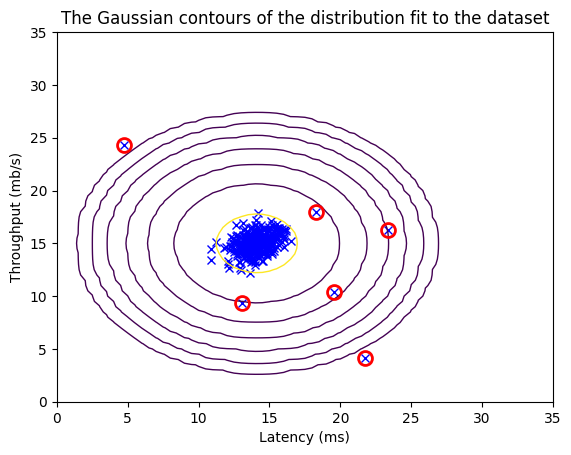

In [37]:
# Find the outliers in the training set 
outliers = p < epsilon

# Visualize the fit
visualize_fit(X_train, mu, var)

# Draw a red circle around those outliers
plt.plot(X_train[outliers, 0], X_train[outliers, 1], 'ro',
         markersize= 10,markerfacecolor='none', markeredgewidth=2)